In [62]:
import pandas as pd
import numpy as np
import json
import time
import gensim 
from gensim.models import Word2Vec
import pandas as pd 
import math
import numpy as np
import json
from operator import itemgetter
from datetime import datetime
import matplotlib.pyplot as plt
global skipgram_model

In [1]:
dataset_path = '../yelp-dataset/'
filename = 'yelp_academic_dataset_business.json'


start = time.time()
# Store all businesses
data = [json.loads(line) for line in 
        open(dataset_path + filename, 'r', encoding="utf8")]

stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 0.056 mins


In [2]:
# Keep businesses which are located in Toronto
data = [x for x in data if x['city']=='Toronto']
data = np.array(data) # Convert list to numpy array

# Create an array with Toronto located businesses with more than 15 reviews
business_col = np.array([])
for i in range(len(data)):
    if data[i]['review_count']>=15:
        business_col = np.append(business_col,data[i]['business_id'])

In [3]:
# Helping function to check if a business is in business_col (Toronto and >=15 reviews)
def get_business_index(business_id):
    return np.where(business_col == business_id)[0]

In [4]:
filename = 'yelp_academic_dataset_review.json'
start = time.time()

user_business = []
# Read the json review file line by line and keep the reviews referring to business_col 
with open(dataset_path + filename,'r',encoding="utf8") as reviews_file:

    for line in reviews_file:
        line = json.loads(line)
        ind = get_business_index(line['business_id'])

        if ind.size>0:
            user_business.append([line['user_id'],line['business_id'], line['stars'], line['date']])
            
stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 10.328 mins


In [5]:
# User business have all the reviews we want. But using numpy unique will keep the first occurency.
# We want to keep last occurency, so a smart way to do so is to read our list with all pairs of 
# type (UserID, BusinessID, Rating) upside-down(reverse). Then call unique and reconstruct the 
# total reviews with the given indices.
user_business.reverse()
user_bus_sorted = sorted(user_business, key=itemgetter(0,1))

user_bus_sorted = np.array(user_bus_sorted)
pairs = user_bus_sorted[:,0:2]
_, idx = np.unique(pairs, axis=0, return_index=True)
total_reviews = user_bus_sorted[idx]

In [6]:
dates = total_reviews[:,3]
for i in range(len(dates)):
    dates[i] = int(datetime.fromisoformat(dates[i]).timestamp())

In [7]:
# Take the userID column and keep the unique users. Do a for-loop to keep users with >=15 reviews.
users = total_reviews[:,0]
unique_users, counts = np.unique(users, return_counts=True)
uniq_users = []

for i in range(len(unique_users)):
    if counts[i]>=15:
        uniq_users.append(unique_users[i])
uniq_users = np.array(uniq_users)

# Here keep the unique businesses column
businesses = total_reviews[:,1]
unique_businesses = np.unique(businesses)

start = time.time()
# Create the sparse_array using the unique users(rows) and unique businesses (columns)
sparse = np.zeros((len(unique_businesses), len(uniq_users)))
sparse_dates = np.zeros((len(unique_businesses), len(uniq_users)))
for i in range(len(unique_businesses)):
    user_index = np.where(unique_businesses[i] == total_reviews)[0]
    temp = []
    for j in range(len(user_index)):
        unique_user_ind = np.where(total_reviews[user_index[j]][0] == uniq_users) 
        if unique_user_ind[0].size>0:
            sparse[i][unique_user_ind[0][0]] = int(float(total_reviews[user_index[j]][2]))
            sparse_dates[i][unique_user_ind[0][0]] = int(total_reviews[user_index[j]][3])
stop = time.time()
print("Sparse array created in {:.3f} mins".format((stop-start)/60))

# Sparse array shape indicates the initial unique users and unqiue businesses
sparse.shape

Sparse array created in 3.769 mins


(7602, 5677)

In [8]:
# Prune until nothing to delete

stop=0
while(stop==0):
    # prune the rows(businesses with below 15 reviews)
    index_to_delete = []
    for i in range(sparse.shape[0]):
        nonzero_indexes = np.nonzero(sparse[i])
        if len(nonzero_indexes[0])<15:
            index_to_delete.append(i)
            
    #make new sparse array with deleted items and unique_businesses to track ids
    unique_businesses = np.delete(unique_businesses, index_to_delete)
    sparse = np.delete(sparse, index_to_delete, axis=0)
    sparse_dates = np.delete(sparse_dates, index_to_delete, axis=0)
    
    #prune the columns(users)
    transposed_sparse = np.transpose(sparse)
    columns_to_delete = []
    for i in range(transposed_sparse.shape[0]):
        nonzero_values = np.nonzero(transposed_sparse[i])
        if len(nonzero_values[0])<15:
            columns_to_delete.append(i)
            
    #make new sparse array with deleted items and uniq_users to track ids
    uniq_users = np.delete(uniq_users, columns_to_delete)
    sparse = np.delete(sparse, columns_to_delete, axis=1)
    sparse_dates = np.delete(sparse_dates, columns_to_delete, axis=1)
    
    # If nothing to delete -> stop
    if len(index_to_delete)==0 and len(columns_to_delete)==0:
        stop=1

# After pruning we have our sparse array reshaped
sparse.shape

(4092, 4794)

In [9]:
# Create the new data, create a list([userID,businessID,rating]) using our sparse array data
data_csv = []
start = time.time()
for i in range(sparse.shape[1]):
    for j in range(sparse.shape[0]):
        if sparse[j][i]>0:
            data_csv.append([uniq_users[i],unique_businesses[j], sparse[j][i], sparse_dates[j][i]])
stop = time.time()
print("Data list created in {:.3f} mins".format((stop-start)/60))

Data list created in 0.214 mins


In [10]:
data_csv = sorted(data_csv, key=itemgetter(0,3))
len(data_csv)
data_np = np.array(data_csv)

In [11]:
# We have the file ready from Step 1
data_table = pd.DataFrame(data_csv, columns = ['user_id', 'business_id', 'rating', 'date'])
print(data_table)

                       user_id             business_id  rating          date
0       --BumyUHiO_7YsHurb9Hkw  vcxvQyAggPqxcHwvJXvjGg     5.0  1.484308e+09
1       --BumyUHiO_7YsHurb9Hkw  r_BrIgzYcwo1NAuG9dLbpg     4.0  1.484310e+09
2       --BumyUHiO_7YsHurb9Hkw  iZJ5pdY558VodrEumGyVug     5.0  1.484836e+09
3       --BumyUHiO_7YsHurb9Hkw  q5xrVJ4kivx_yEfJeOKNYQ     4.0  1.485190e+09
4       --BumyUHiO_7YsHurb9Hkw  xsl-d_opm3AU5H2Z-im33g     4.0  1.485190e+09
...                        ...                     ...     ...           ...
197107  zzmhLxcZ4XZQyz95c_KbOA  ACBFbEW6oa58_RyX9Op-qQ     5.0  1.542595e+09
197108  zzmhLxcZ4XZQyz95c_KbOA  lOKgoQtMhnlf6hWvrOiMtQ     2.0  1.546395e+09
197109  zzmhLxcZ4XZQyz95c_KbOA  9HWdRtNS0q4_UkEvL14IfA     3.0  1.546396e+09
197110  zzmhLxcZ4XZQyz95c_KbOA  bNHeKmkBx5emT9xLfdWyjw     5.0  1.546397e+09
197111  zzmhLxcZ4XZQyz95c_KbOA  FyUcIAn8timIFybYpOLbAw     5.0  1.546397e+09

[197112 rows x 4 columns]


In [13]:
print("Sample data should have {} rows \n".format(math.ceil(len(data_np)*0.05)))
sample_data = data_table.sample(frac=0.05)
print(len(sample_data))

Sample data should have 9856 rows 

9856


In [14]:
# Setting sample ratings to zero
for index in sample_data.index:
    data_table.at[index, 'rating'] = 0

In [15]:
# Create the numpy array, unique_users and unique_business lists
data_table_R = data_table.to_numpy()
unique_users = np.unique(data_table_R[:,0])
unique_business = np.unique(data_table_R[:,1])

In [16]:
start = time.time()

sparse_array = np.zeros((len(unique_users), len(unique_business)))
# Create the sparse_array
for i in range(len(unique_users)):
    # Take all business index that a user has a rating
    business_index = np.where( unique_users[i] == data_table['user_id']) 
    
    # For all the businesses indexes find its index in unique_business and assign that index value
    # in the sparse array too.
    for j in range(len(business_index[0])):
        temp_business = data_table['business_id'][business_index[0][j]] #take business_id for given index
        unique_business_ind = np.where(temp_business == unique_business)
        sparse_array[i][unique_business_ind[0][0]] = data_table['rating'][business_index[0][j]]

stop = time.time()
print("Sparse array created in {:.3f} mins".format((stop-start)/60))

Sparse array created in 3.096 mins


### Create text: for every user keep the business ids he has rated

In [17]:
j=0
embedding = ['']
for i in range(data_table_R.shape[0]):
    if data_table_R[i][0] == data_table_R[i-1][0]:
        embedding[j] += ' ' + data_table_R[i][1]
    else:
        embedding.append(data_table_R[i][1])
        j+=1
embedding = embedding[1:]

for i in range(len(embedding)):
    embedding[i] = embedding[i].split(" ")
    
    
len(embedding) # We have all the business ids for each user (which he has a rating only)

### Helping functions to calculate similarites (cosine similarites) using wv.similarity()

In [38]:
sample_array = sample_data.to_numpy()

In [37]:
def find_index(user_id):
    ind = np.where(user_id  == unique_users)
    return ind[0][0]
def find_business(business_id):
    ind = np.where(business_id == unique_business)
    return ind[0][0]
def find_business_similarity(business1, business2):
    return skipgram_model.wv.similarity(business1, business2)
def find_user_similarity(user1, user2):
    return skipgram_model.wv.similarity(user1, user2)

### Function that builds skipgram model for given window size

In [40]:
def make_model(w):
    embedding_size = 100
    skipgram_model = gensim.models.Word2Vec(embedding, min_count = 1,size = embedding_size, window = w, sg = 1)

In [39]:
def ICF_prediction(business1, common_businesses, ratings, k_values):
    business_ind1 = find_business(business1)
    similar = []
    predictions_k = []
    
    # For every common business find its' similarity to our business
    for i in range(len(common_businesses)):
        temp_ind = find_business(common_businesses[i])
        similar.append([common_businesses[i], find_business_similarity(business1,
                        common_businesses[i]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our business
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]

        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Execute ICF for all values of k

In [41]:
predictions = []
user_avg_pred = []
icf_predictions = []
k_values = [1,5,10,20,40,50,60,70,80,100]
window = [10, 50, 100, 1000]
transposed_sparse = np.transpose(sparse_array)

start = time.time()
for w in window:
    make_model(w)
    predictions = []
    for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
        common_ratings = [] # RATINGS OF ALL BUSINESS BY USER
        common_businesses = [] # ALL BUSINESSES THE GIVEN USER HAS RATED
        user_index = find_index(sample_array[i][0]) # Get user index
        common_business_indexes = np.nonzero(sparse_array[user_index,:]) # FIND BUSINESSES INDEXES FOR NONZERO VALUES ONLY!

        for j in range(len(common_business_indexes[0])): # For every row in spars- (Actually for every rated business)
            common_ratings.append(transposed_sparse[common_business_indexes[0][j]][user_index]) # Append ratings
            common_businesses.append(unique_business[common_business_indexes[0][j]]) # Append the user_id
        # Append the prediction
        #user_avg_pred.append(sum(common_ratings)/len(common_ratings))
        predictions.append(ICF_prediction(sample_array[i][1], common_businesses, common_ratings, k_values))

    icf_predictions.append(np.array(predictions))

stop = time.time()
print("ICF predictions for all given k values in {:.3f} mins".format((stop-start)/60))

ICF predictions for all given k values in 16.382 mins


#### (icf_predictions is a list with 4 numpy arrays, each array for every window size [10,50,100,1000])

#### Prepare data for UCF predictions here, sort (user,business,rating) by (business,rating)

In [54]:
data_table_R = sorted(data_table_R.tolist(), key=itemgetter(1,3))
data_table_R = np.array(data_table_R)
data_table_R[:10]

array([['HFItzRohDHZvcKDrM6ABZg', '--SrzpvFLwP_YFwB_Cetow', '4.0',
        '1298920068.0'],
       ['2vJ2e51kdbdAmAo_HTr4KQ', '--SrzpvFLwP_YFwB_Cetow', '4.0',
        '1307529842.0'],
       ['Jt1zgNmwz_jheOSmEsljPQ', '--SrzpvFLwP_YFwB_Cetow', '4.0',
        '1314987529.0'],
       ['ay4M5J28kBUf0odOQct0BA', '--SrzpvFLwP_YFwB_Cetow', '2.0',
        '1318282712.0'],
       ['TZelLnaGbHgaG7LBI6rfgg', '--SrzpvFLwP_YFwB_Cetow', '5.0',
        '1328832120.0'],
       ['lr-uNDv2NMIURR8WT9Z2GQ', '--SrzpvFLwP_YFwB_Cetow', '4.0',
        '1356715248.0'],
       ['GQ8l3o7-_jL0WNHUkNlhJA', '--SrzpvFLwP_YFwB_Cetow', '4.0',
        '1376390886.0'],
       ['MxY_ArQomVBNKPIt2FtgyQ', '--SrzpvFLwP_YFwB_Cetow', '2.0',
        '1399743009.0'],
       ['orh0HRUNCWuQMt9Iia_osg', '--SrzpvFLwP_YFwB_Cetow', '4.0',
        '1419691326.0'],
       ['EiP1OFgs-XGcKZux0OKWIA', '--SrzpvFLwP_YFwB_Cetow', '3.0',
        '1421113598.0']], dtype='<U22')

### Create again the text, now for each business we store user ids who have rated the business

In [55]:
j=0
embedding = ['']
for i in range(data_table_R.shape[0]):
    if data_table_R[i][1] == data_table_R[i-1][1]:
        embedding[j] += ' ' + data_table_R[i][0]
    else:
        embedding.append(data_table_R[i][0])
        j+=1
embedding = embedding[1:]

for i in range(len(embedding)):
    embedding[i] = embedding[i].split(" ")

len(embedding)

4092

In [56]:
def UCF_prediction(user1, common_users, ratings, k_values):
    user_ind1 = find_index(user1)
    similar = []
    predictions_k = []
    # For every common user find his similarity to our user
    for i in range(len(common_users)):
        temp_ind = find_index(common_users[i])
        similar.append([common_users[i], find_user_similarity(user1, common_users[i]), int(ratings[i])])
    
    # Sort similarities and take k most similar to our user
    vectors = np.array(sorted(similar, key=itemgetter(1), reverse=True))
    
    # For every given k calculate the predictions for the given user
    for k in range(len(k_values)):
        temp_vectors = vectors[:k_values[k]]
        
        similarity_vector = temp_vectors[:,1].astype(float)
        ratings_vector = temp_vectors[:,2].astype(int)

        # Calculate prediction
        numerator = 0
        denominator = np.sum(similarity_vector)
        for i in range(len(similarity_vector)):
            numerator += similarity_vector[i]*ratings_vector[i]
        predictions_k.append(numerator/denominator)
        
    # Return a list with predictions for the user for every k value
    return predictions_k

### Execute UCF for all values of k

In [57]:
predictions = []
ucf_predictions = []
business_avg_pred = []
k_values = [1,5,10,20,50,100,200,500,1000]
window = [10, 50, 100, 1000]

start = time.time()
for w in window:
    make_model(w)
    predictions = []
    for i in range(sample_array.shape[0]): # For every pair (u,b) that have missing rating
        common_users = [] # USER_IDS THAT ALSO RATED THE GIVEN BUSINESS
        common_ratings = [] # AND THEIR RATINGS
        business_index = find_business(sample_array[i][1]) # Get business index
        common_users_indexes = np.nonzero(sparse_array[:,business_index]) # FIND INDEXES FOR NONZERO VALUES ONLY!
        for j in range(len(common_users_indexes[0])): # For every row in spars- (Actually for every user)
            common_ratings.append(sparse_array[common_users_indexes[0][j]][business_index]) # Append ratings
            common_users.append(unique_users[common_users_indexes[0][j]]) # Append the user_id

        # Append the prediction
        predictions.append(UCF_prediction(sample_array[i][0], common_users, common_ratings, k_values))
        business_avg_pred.append(sum(common_ratings)/len(common_ratings))

    ucf_predictions.append(np.array(predictions))

stop = time.time()
print("UCF predictions for all given k values in {:.3f} mins".format((stop-start)/60))

UCF predictions for all given k values in 19.912 mins


#### (Same as icf_predictions, ucf_prediction is a list with 4 numpy arrays, each array for every window size [10,50,100,1000])

In [58]:
true_ratings = sample_data['rating'].values.astype(float).astype(int)

############################
# RMSE FOR UCF
RMSE_UCF = []
for x in ucf_predictions:
    temp_UCF = []
    for i in range(9):
        predicted_ratings = np.array(x[:,i])
        sum_of_difference = 0
        for j in range(sample_data.shape[0]):
            sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
        temp_UCF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))
    RMSE_UCF.append(np.array(temp_UCF))
############################
# RMSE FOR ICF
RMSE_ICF = []
for x in icf_predictions:
    temp_ICF = []
    for i in range(10):
        predicted_ratings = np.array(x[:,i])
        sum_of_difference = 0
        for j in range(sample_data.shape[0]):
            sum_of_difference += (predicted_ratings[j] - true_ratings[j])**2
        temp_ICF.append(math.sqrt(sum_of_difference/sample_data.shape[0]))
    RMSE_ICF.append(np.array(temp_ICF))

In [59]:
RMSE_ICF

[array([1.39365299, 1.07756928, 1.03516771, 1.02028116, 1.01720653,
        1.01709996, 1.01702835, 1.01752141, 1.0174876 , 1.01788621]),
 array([1.38690244, 1.06536387, 1.02831808, 1.01384005, 1.01330095,
        1.01283297, 1.01323861, 1.01352988, 1.01397056, 1.01459584]),
 array([1.37093555, 1.0660448 , 1.02584719, 1.0156407 , 1.0139847 ,
        1.01383458, 1.01406964, 1.01447368, 1.01477774, 1.01528704]),
 array([1.37879494, 1.07078057, 1.03456698, 1.01789314, 1.01504269,
        1.01488149, 1.01502457, 1.01558444, 1.01618822, 1.0168415 ])]

#### RMSE_ICF[0] stores RMSE results for window = 10, RMSE_UCF[1] stores RMSE results for window =100 etc.

In [85]:
# print min for each window size value
for x in RMSE_ICF:
    print (x.min())

1.0170283456489912
1.012832973349219
1.013834577607475
1.0148814934104429


In [86]:
# print min for each window size value
for x in RMSE_UCF:
    print (x.min())

0.9850424259544127
0.9845275516236751
0.9849928328695136
0.9856381550721055


### Tested again previous UCF, ICF (previous assignment)

In [68]:
RMSE_ICF_previous = [1.3635518101491555,
                     1.0772033995797512,
                     1.0396278436795934,
                     1.0275865663136554,
                     1.0249605732956646,
                     1.0245224756304048,
                     1.024604685369257,
                     1.0246579778720535,
                     1.0247579860236267,
                     1.0247893207656449]

RMSE_UCF_previous = [1.3550425905033103,
                     1.0620262972287904,
                     1.0250811310343149,
                     1.010437295328418,
                     1.0056540920516426,
                     1.0048084863720939,
                     1.0049795638040333,
                     1.0050683918803203,
                     1.0050728663338302]

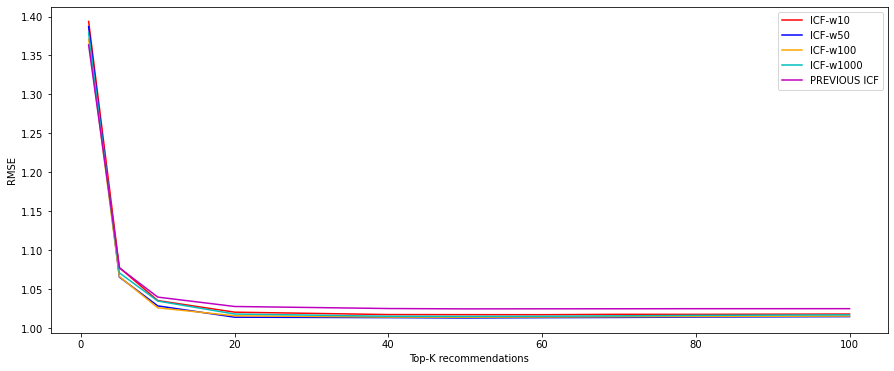

In [87]:
plt.figure(figsize=(15, 6))
x = [1,5,10,20,40,50,60,70,80,100]
plt.plot(x, RMSE_ICF[0], "r", label = "ICF-w10")
plt.plot(x, RMSE_ICF[1], "b", label = "ICF-w50")
plt.plot(x, RMSE_ICF[2], "orange", label = "ICF-w100")
plt.plot(x, RMSE_ICF[3], "c", label = "ICF-w1000")
plt.plot(x, RMSE_ICF_previous, "m", label = "PREVIOUS ICF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

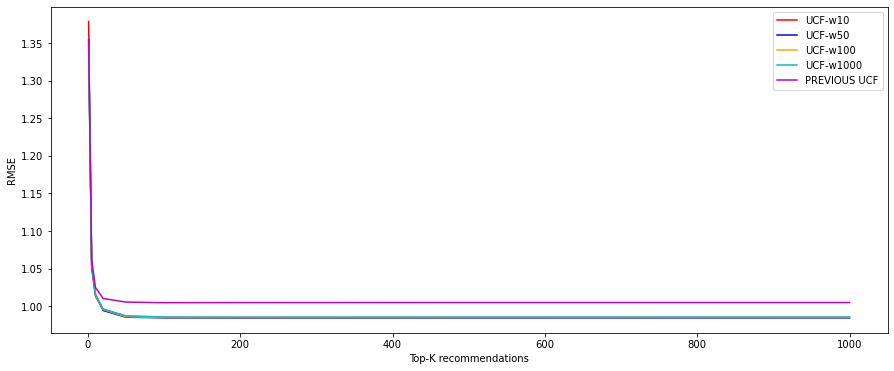

In [71]:
plt.figure(figsize=(15, 6))
x = [1,5,10,20,50,100,200,500,1000]
plt.plot(x, RMSE_UCF[0], "r", label = "UCF-w10")
plt.plot(x, RMSE_UCF[1], "b", label = "UCF-w50")
plt.plot(x, RMSE_UCF[2], "orange", label = "UCF-w100")
plt.plot(x, RMSE_UCF[3], "c", label = "UCF-w1000")
plt.plot(x, RMSE_UCF_previous, "m", label = "PREVIOUS UCF")
plt.legend()
plt.ylabel("RMSE")
plt.xlabel("Top-K recommendations");

From the plots we observe that the way to predict the missing values with word embeddings using skipgram model is better for the ICF algorithm and for w=50 we have the best results followed by w=100, w=1000, w=10.
<br>
<br>
UCF algorithm behaves even more better than previous experiment. Also here we observe that the best result we have are for values with window = 50 followed by w=100, w=10, w=1000.